#### Training

This notebook contains pipeline to train a semantic segmentation model to segment roofs from aerial imagery.<br>
Dataset used - **AIRS** : https://www.airs-dataset.com/ <br>


In [23]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' #selecting which GPU device to use

Importing packages

In [2]:
import warnings
from ast import literal_eval
import random
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import cv2
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import tifffile
from sklearn.model_selection import KFold
import glob
import torch_optimizer as t_optim #ranger optimizer -https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
import utils
import cv2
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import zarr

We convert the dataset to Zarr groups for fast retrieval 
### **just run one time i.e., first time** 
For future runs, run directly from the **Dataset** section 

In [3]:
#path to train images, train masks, valid images, valid masks 

train_images_path = "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/train/image/"
train_mask_path = "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/train/label/"
valid_images_path = "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/val/image/"
valid_mask_path =  "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/val/label/"


In [4]:
#creating a CSV with columns filename, image_path, mask_path for both train and valid datasets

data_train = []
for im in os.listdir(train_images_path):
    data_train.append([im,train_images_path+im,train_mask_path+im,0])
    if not os.path.isfile(train_images_path+im) and not os.path.isfile(train_mask_path+im):
        print(train_images_path+im)
        
        
data_valid= []
for im in os.listdir(valid_images_path):
    data_valid.append([im,valid_images_path+im,valid_mask_path+im,0])
    if not os.path.isfile(valid_images_path+im) and not os.path.isfile(valid_mask_path+im):
        print(valid_images_path+im)

            


In [20]:
pd.DataFrame(data_train,columns=["filename","image_path","mask_path","annot_counts"]).to_csv("train_data.csv",index=None)
pd.DataFrame(data_valid,columns=["filename","image_path","mask_path","annot_counts"]).to_csv("valid_data.csv",index=None)

In [21]:
train_images_zarr_savepath = "train_images_zarr"
train_masks_zarr_savepath = "train_masks_zarr"
val_images_zarr_savepath = "val_images_zarr"
val_masks_zarr_savepath = "val_masks_zarr"

Creating Zarr groups

In [22]:

train_img_group = zarr.group(train_images_zarr_savepath)
train_mask_group = zarr.group(train_masks_zarr_savepath)
val_img_grp =  zarr.group(val_images_zarr_savepath)
val_mask_grp =  zarr.group(val_masks_zarr_savepath)

Reading csvs that we just created

In [44]:
train_csv = pd.read_csv("train_data.csv")
valid_csv = pd.read_csv("valid_data.csv")

Iterating over the masks from train and test datasets, extracting contours for regions annotated as roof <br>
Saving the contour centroids with respect to each mask for future use

In [45]:
mask_centroid_lists = []
for data in tqdm( train_csv.iterrows()):
    cent = []
    mask = tifffile.imread(data[1]['mask_path'])
    contours, hierarchies = cv2.findContours(np.uint8(mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # print(contour_random_selected)
    for c in contours:
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        cent.append([cx,cy])
    mask_centroid_lists.append(cent)
    

mask_centroids_val = []
for data in tqdm( valid_csv.iterrows()):
    cent = []
    mask = tifffile.imread(data[1]['mask_path'])
    contours, hierarchies = cv2.findContours(np.uint8(mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # print(contour_random_selected)
    for c in contours:
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        cent.append([cx,cy])
        
    mask_centroids_val.append(cent)

   
    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [46]:
#adding centroid information to the dataframe
train_csv['region_centroids'] = mask_centroid_lists
valid_csv['region_centroids'] = mask_centroids_val

train_csv.to_csv("train_data.csv",index=None)
valid_csv.to_csv("valid_data.csv",index=None)

### **Adding the image data to zarr group**

In [26]:
#train data
for data in tqdm( train_csv.iterrows(),total=len(train_csv)):
    train_img_group[data[1]["filename"]] = tifffile.imread(data[1]['image_path'])
    train_mask_group[data[1]["filename"]] = tifffile.imread(data[1]['mask_path'])
    
    

  0%|          | 0/857 [00:00<?, ?it/s]

In [27]:
#val data
for data in tqdm( valid_csv.iterrows(),total=len(valid_csv)):
    val_img_grp[data[1]["filename"]] = tifffile.imread(data[1]['image_path'])
    val_mask_grp[data[1]["filename"]] = tifffile.imread(data[1]['mask_path'])
    
    

  0%|          | 0/94 [00:00<?, ?it/s]

### Dataset - Defining a dataset 

The feature of the dataset defined below :
- For every yield, for a given image it randomly samples a contour centroid.
- Extract a patch of resolution 512x512 around it
- Apply transformations and augmentations
- Encoder specific preprocessing

In [5]:
        
class AIRS_dataset_dynamic(Dataset):
    def __init__(self,data_csv_path:str="train_data.csv",zarr_im_path="",zarr_mask_path="",indexes:list= None,transform:transforms = None, target_transform:transforms=None,preprocessing=None,patch_size=(512,512,3)):
        self.data = pd.read_csv(data_csv_path)
        self.indexed_data = self.data.iloc[indexes,:] #helps to pick particular images in training set based on the indices
        self.transform = transform
        self.target_transform = target_transform
        self.preprocessing = preprocessing
        self.patch_size = patch_size
        self.image_zar = zarr.open_group(zarr_im_path)
        self.mask_zar = zarr.open_group(zarr_mask_path)
        
    def __getitem__(self,idx):
        # print("imname",self.indexed_data.iloc[idx,1])
        image = self.image_zar[self.indexed_data.iloc[idx,0]]
        mask =  self.mask_zar[self.indexed_data.iloc[idx,0]]
        cent_list = literal_eval(self.indexed_data.iloc[idx,-1])
        
        if len(cent_list)==0:
            cy,cx = random.randint(0,image.shape[1]),random.randint(0,image.shape[0])
        else:
            cy,cx = random.sample(cent_list,1)[0]
        cx = cx-self.patch_size[0]//2 if cx-self.patch_size[0]//2>0 else 0
        cy = cy-self.patch_size[1]//2 if cy-self.patch_size[1]//2>0 else 0
        
        cx = cx if cx+self.patch_size[0]<image.shape[0] else cx-self.patch_size[0]
        cy = cy if cy+self.patch_size[1]<image.shape[1] else cy-self.patch_size[1]
       
        patch =image.get_basic_selection((slice(cx,cx+self.patch_size[0]),slice(cy,cy+self.patch_size[1])))
        mask_patch =mask.get_basic_selection((slice(cx,cx+self.patch_size[0]),slice(cy,cy+self.patch_size[1])))*255.0
        if self.transform:
            augmentations = self.transform(image=patch,mask=mask_patch)
            patch,mask_patch = augmentations['image'],augmentations['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=patch,mask=mask_patch)
            patch,mask_patch = preprocessed['image'],preprocessed['mask']
        return patch.float(),(mask_patch[:,:]/255.0).type(torch.LongTensor)
    
    def __len__(self):
        return len(self.indexed_data)  

### Config - defining the model configurations

In [27]:
class Configuration:
    MODEL_SAVEPATH = "models/" #path to save models
    ENCODER = "efficientnet-b2" #encoder to be used
    PRETRAINED_WEIGHTS = "imagenet" #pretrained weights for the encoder
    BATCH_SIZE = 16 #batch size
    INPUT_CHANNELS = 3
    INPUT_SHAPE = (512,512,3)
    CLASSES = 2 
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    EPOCHS = 1
    LOSS_CROSSENTROPY = nn.CrossEntropyLoss() 
    LOSS_FOCAL = sm.losses.FocalLoss(mode="multiclass")
    LOSS_DICE = utils.DiceScore(loss=True)
    DICE_COEF = utils.DiceScore(loss=False)
    WEIGHT_DECAY = 1e-4
    LEARNING_RATE = 1e-3
    PREPROCESS = sm.encoders.get_preprocessing_fn(ENCODER,PRETRAINED_WEIGHTS)
    MODEL_NAME = 0
    ARCHITECTURE = "UNET"
       
cfg = Configuration()  

Validating the dataset implementation

In [8]:
train_data_csv_path = "train_data.csv"
train_images_zarr_path = "train_images_zarr"
train_masks_zarr_path = "train_masks_zarr"
dataframe_im_ids = pd.read_csv(train_data_csv_path).index

In [9]:
train_dataset = AIRS_dataset_dynamic(train_data_csv_path,indexes=dataframe_im_ids,zarr_im_path=train_images_zarr_path,zarr_mask_path=train_masks_zarr_path,transform=utils.get_train_transforms(),preprocessing=utils.preprocessing_fucntion(cfg.PREPROCESS))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


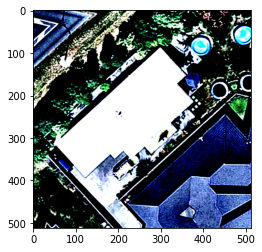

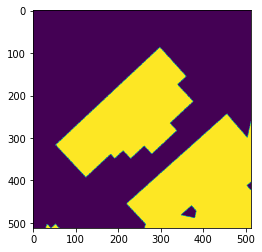

In [21]:
image,mask = train_dataset[0]
plt.imshow(image.numpy().transpose(1,2,0))
plt.show()
plt.imshow(mask)
plt.show()

### Defined the trainer class

In [32]:
class Trainer:
    def __init__(self,cfg:Configuration,train_data_loader:DataLoader,valid_data_loader:DataLoader)->None:
        self.cfg = cfg
        self.patience = 5
        
        
        self.model = sm.Unet(encoder_name=self.cfg.ENCODER, 
                     encoder_weights=self.cfg.PRETRAINED_WEIGHTS, 
                     in_channels=self.cfg.INPUT_CHANNELS, 
                     classes=self.cfg.CLASSES)
        #uncomment for unet++
        # self.model = sm.UnetPlusPlus(encoder_name=self.cfg.ENCODER, 
        #              encoder_weights=self.cfg.PRETRAINED_WEIGHTS, 
        #              in_channels=self.cfg.INPUT_CHANNELS, 
        #              classes=self.cfg.CLASSES)
        
        #replace loss function with self.cfg.LOSS_FOCAL to implement focal loss
        self.loss_function = self.cfg.LOSS_CROSSENTROPY #self.cfg.LOSS_FOCAL#
        self.lr = self.cfg.LEARNING_RATE
        self.batch_size = self.cfg.BATCH_SIZE
        self.train_dataloader = train_data_loader
        self.valid_dataloader = valid_data_loader
        self.device = self.cfg.DEVICE
        self.epochs = self.cfg.EPOCHS
        self.lr = self.cfg.LEARNING_RATE
        self.val_for_early_stopping = 9999999 #early stopping
        if not os.path.isdir(self.cfg.MODEL_SAVEPATH):
            os.makedirs(self.cfg.MODEL_SAVEPATH)
        
        
            
            
        self.log = pd.DataFrame(columns=["model_name","train_loss","train_dice","valid_loss","valid_dice"])
        
        
        #using ranger optimizer
        self.optimizer = t_optim.Ranger(self.model.parameters(),weight_decay=self.cfg.WEIGHT_DECAY)
        
        
   
    
    def calculate_metrics(self,data_loader:DataLoader):
        self.model.eval()
        total_loss = 0
        total_dice = 0 #batch wise dice loss
        with torch.no_grad():
            for data in tqdm(data_loader,total=len(data_loader)):
                im = data[0].to(self.device)
                mask = data[1].to(self.device)
                out = self.model(im)
                loss = self.loss_function(out.data,mask) #+ cfg.LOSS_DICE(out,mask)
                total_loss+=loss.item()
                total_dice+= self.cfg.DICE_COEF(out.data.to("cpu"),mask.cpu())
        return total_dice/len(data_loader),total_loss/len(data_loader)

    
    def earlystopping(self,val_loss):
        #early stopping
        
        if val_loss < self.val_for_early_stopping:
            self.val_for_early_stopping = val_loss
            return True
        else:
            self.patience-=1
            return False
 
    def fit(self)->None:
        print("started fitting the model")
        best_loss = 9999999
        
        for epoch in range(self.epochs):
            self.model.train()
            self.model.to(self.device)
            
            dice_score_ = 0
            loss_ = 0
            
            for j,data in enumerate(tqdm(self.train_dataloader,total = len(self.train_dataloader))):
                input_image_batch = data[0].to(self.device)
                mask_batch = data[1].to(self.device)
                self.optimizer.zero_grad()
                output = self.model(input_image_batch)
                loss = self.loss_function(output,mask_batch)#+cfg.LOSS_DICE(output,mask_batch.unsqueeze(1))
                loss.backward()
                self.optimizer.step()
                loss_+=loss.item()
            
                dice_score_+= self.cfg.DICE_COEF(output.data.to("cpu"),mask_batch.to("cpu"))

            
            dice_score_valid,loss_valid, = self.calculate_metrics(self.valid_dataloader)
            train_dice = dice_score_/len(self.train_dataloader)
            train_loss = loss_/len(self.train_dataloader)
            print(f"train dice score : {train_dice}, train loss {train_loss}")
            print(f"valid dice score : {dice_score_valid}, valid loss {loss_valid}")
            
            self.log.loc[epoch,:] = [f"{self.cfg.ENCODER}_{self.cfg.ENCODER}.pth",f"{train_loss}",f"{train_dice}",f"{loss_valid}",f"{dice_score_valid}"]
            self.log.to_csv(self.cfg.MODEL_SAVEPATH+f"/{self.cfg.MODEL_NAME}__{self.cfg.ENCODER}_{self.cfg.BATCH_SIZE}_Valid_slicing_all.csv",index=False)
            
            if self.patience >= 0 and self.earlystopping(loss_valid):
                print("saving model")
                
                torch.save(self.model.state_dict(),self.cfg.MODEL_SAVEPATH+f"/{self.cfg.MODEL_NAME}_{self.cfg.ENCODER}_{self.cfg.BATCH_SIZE}_Valid_slicing_all.pth")
                self.patience= 5
                
            
            if self.patience <= 0:
                print("Training terminated, no improvement in valid loss")
                break
                
        
        
        

        

#### Model Training

In [33]:
train_data_csv_path = "train_data.csv"
valid_data_csv_path = "valid_data.csv"

train_images_zarr_path = "train_images_zarr"
train_masks_zarr_path = "train_masks_zarr"
val_images_zarr_path = "val_images_zarr"
val_masks_zarr_path = "val_masks_zarr"

def training(train_data_csv_path:str,valid_data_csv_path:str)->pd.DataFrame:
    #get all the training data unique image ids
    train_ids = pd.read_csv(train_data_csv_path).index
    valid_ids = pd.read_csv(valid_data_csv_path).index
    
    train_dataset = AIRS_dataset_dynamic(train_data_csv_path,indexes=train_ids,zarr_im_path=train_images_zarr_path,zarr_mask_path=train_masks_zarr_path,transform=utils.get_train_transforms(),preprocessing=utils.preprocessing_fucntion(cfg.PREPROCESS))
    valid_dataset = AIRS_dataset_dynamic(valid_data_csv_path,indexes=valid_ids,zarr_im_path=val_images_zarr_path,zarr_mask_path=val_masks_zarr_path,preprocessing=utils.preprocessing_fucntion(cfg.PREPROCESS))

    train_dataloader = DataLoader(train_dataset,batch_size=cfg.BATCH_SIZE,shuffle=True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=cfg.BATCH_SIZE,shuffle=False)
    cfg.MODEL_NAME =  cfg.ARCHITECTURE
    trainer =Trainer(cfg,train_dataloader,valid_dataloader)
    trainer.fit()        



    


In [30]:
training(train_data_csv_path,valid_data_csv_path)

started fitting the model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.6568679809570312, train loss 0.3619109902668882
valid dice score : 0.7167482972145081, valid loss 0.24241802096366882
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.7440813779830933, train loss 0.20872498552004495
valid dice score : 0.7894423007965088, valid loss 0.15911613404750824
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8009406328201294, train loss 0.14548795891028862
valid dice score : 0.8651764392852783, valid loss 0.09085101758440335
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8455794453620911, train loss 0.10901119780761225
valid dice score : 0.8900505900382996, valid loss 0.07201757157842319
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8707290887832642, train loss 0.09056570587886704
valid dice score : 0.8941680788993835, valid loss 0.06669600618382295
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8883944153785706, train loss 0.07795706805255678
valid dice score : 0.9229567050933838, valid loss 0.05030195415019989
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8978946805000305, train loss 0.07204235890121372
valid dice score : 0.9259718060493469, valid loss 0.0492621889958779
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9084042906761169, train loss 0.06297967941672714
valid dice score : 0.9265029430389404, valid loss 0.04762021079659462
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.914692223072052, train loss 0.06211017106694204
valid dice score : 0.9361531138420105, valid loss 0.04314349529643854
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9200394153594971, train loss 0.057215654463679703
valid dice score : 0.9374533295631409, valid loss 0.04221216278771559
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9205992817878723, train loss 0.057395456151829824
valid dice score : 0.9455390572547913, valid loss 0.03764080194135507
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9251357316970825, train loss 0.054000609588843805
valid dice score : 0.9508922100067139, valid loss 0.033455378065506615
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9269662499427795, train loss 0.054609155006430765
valid dice score : 0.9416304230690002, valid loss 0.03845415823161602


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9328930974006653, train loss 0.04823686548129276
valid dice score : 0.9462496638298035, valid loss 0.03703790716826916


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9330243468284607, train loss 0.048158287450119304
valid dice score : 0.9383442997932434, valid loss 0.0393267422914505


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9317097067832947, train loss 0.0511571541428566
valid dice score : 0.9489730000495911, valid loss 0.0343653637294968


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9273055791854858, train loss 0.05326034125216581
valid dice score : 0.9499683380126953, valid loss 0.03405282522241274
Training terminated, no improvement in valid loss
